<a href="https://colab.research.google.com/github/NajimovOtabek/net_intrusion_detection/blob/UNSW-NB15_1/Comparing_batchsizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown --id 1AaFPfmUsKhplxHukzQ0k7DKZgEUiDV4A
!gdown --id 1IlPVdYv0gGZFJxNclcbUf46vHrWhLWeS

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AaFPfmUsKhplxHukzQ0k7DKZgEUiDV4A
To: /content/UNSW_NB15_training-set.csv
100% 15.4M/15.4M [00:00<00:00, 45.3MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IlPVdYv0gGZFJxNclcbUf46vHrWhLWeS
To: /content/UNSW_NB15_testing-set.csv
100% 32.3M/32.3M [00:00<00:00, 44.8MB/s]


In [2]:
!wget https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py

--2023-09-28 04:56:29--  https://raw.githubusercontent.com/Jumabek/net_intrusion_detection/develop/preprocessing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3790 (3.7K) [text/plain]
Saving to: ‘preprocessing.py’

preprocessing.py    100%[===================>]   3.70K  --.-KB/s    in 0s      

2023-09-28 04:56:29 (71.4 MB/s) - ‘preprocessing.py’ saved [3790/3790]



In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, brier_score_loss
from preprocessing import read_data, load_data, normalize
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.preprocessing import LabelEncoder, Normalizer
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

In [4]:
data_train = pd.read_csv("UNSW_NB15_training-set.csv")
data_test = pd.read_csv("UNSW_NB15_testing-set.csv")

In [5]:
data_train = data_train.drop(columns="service")
data_test = data_test.drop(columns="service")
data_train = data_train.drop(columns="attack_cat")
data_test = data_test.drop(columns="attack_cat")

In [6]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def make_value2index(attacks):
    attacks = sorted(attacks)
    return {attack: i for i, attack in enumerate(attacks)}

# changes label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = np.array([labels_d[attack] for attack in Y_str])
    return Y

def normalize(data):
    data = data.astype(np.float32)
    eps = 1e-15
    mask = data == -1
    data[mask] = 0
    mean_i = np.mean(data, axis=0)
    min_i = np.min(data, axis=0)
    max_i = np.max(data, axis=0)
    r = max_i - min_i + eps
    data = (data - mean_i) / r
    data[mask] = 0
    return data

def load_data(data):
    num_records, num_features = data.shape  # Use shape instead of size()
    print(f"There are {num_records} flow records with {num_features} feature dimensions.")


    # Strip the whitespace from column names
    data = data.rename(columns=lambda x: x.strip())
    print("Stripped column names.")

    # Handle missing values (NaN)
    nan_count = data.isnull().sum().sum()
    print(f"There are {nan_count} NaN entries.")
    if nan_count > 0:
        data.fillna(data.mean(), inplace=True)
        print("Filled NaN entries with column mean.")

    # Convert 'proto' and 'state' columns to numeric using Label Encoding, if they exist
    if 'proto' in data.columns and 'state' in data.columns:
        label_encoder = LabelEncoder()
        data['proto'] = label_encoder.fit_transform(data['proto'])
        data['state'] = label_encoder.fit_transform(data['state'])
        #data['attack_cat'] = label_encoder.fit_transform(data['attack_cat'])
        print("Converted 'proto' and 'state' columns to numeric using Label Encoding.")

    # Convert all columns to float type
    data = data.astype(float)
    print("Converted all columns to numeric types.")

    # Ensure there are no NaN values
    assert data.isnull().sum().sum() == 0, "There should not be any NaN values."
    return (data)


In [7]:
data_train = load_data(data_train)
data_test = load_data(data_test)

There are 82332 flow records with 43 feature dimensions.
Stripped column names.
There are 0 NaN entries.
Converted 'proto' and 'state' columns to numeric using Label Encoding.
Converted all columns to numeric types.
There are 175341 flow records with 43 feature dimensions.
Stripped column names.
There are 0 NaN entries.
Converted 'proto' and 'state' columns to numeric using Label Encoding.
Converted all columns to numeric types.


In [8]:
X_train = data_train.iloc[:, :-1].values
X_train = normalize(X_train)
y_train = data_train.iloc[:, -1].values
X_test = data_test.iloc[:, :-1].values
X_test = normalize(X_test)
y_test = data_test.iloc[:, -1].values

# Assuming X_train and y_train are your training data and labels
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [9]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [10]:
# Create datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))


# Create a TensorDataset for the validation set
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
from sklearn.metrics import confusion_matrix

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=18, nhead=4, num_layers=4, dim_feedforward=128, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add a fake batch dimension for the transformer
        x = self.transformer(x, x)  # Encoder-Decoder Self-Attention
        x = x.squeeze(1)
        x = self.fc(x)
        return x


In [12]:
from sklearn.metrics import balanced_accuracy_score, classification_report


def evaluate_model(model, data_loader):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.cuda()
            labels = labels.cuda()

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')

    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
    macro_precision = precision_score(true_labels, predicted_labels, average='macro')
    macro_recall = recall_score(true_labels, predicted_labels, average='macro')

    print("Classification Report : \n", classification_report(true_labels, predicted_labels))

    return accuracy, balanced_accuracy, f1, precision, recall, macro_f1, macro_precision, macro_recall, true_labels, predicted_labels


In [13]:
# Model Configuration
input_dim = X_train.shape[1]

unique_classes = np.unique(np.concatenate([y_train, y_test]))
num_classes = len(unique_classes)

In [14]:
# Initialize a dictionary to hold metrics for different batch sizes
all_metrics = {}

batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 3072, 4096, 5120]
num_epochs = 10
patience = 2

###44 minutes

In [32]:
for batch_size in batch_sizes:
    best_val_balanced_acc = 0.0
    epochs_no_improve = 0  # Counter for early stopping

    train_losses = []
    val_accuracies = []
    val_balanced_accuracies = []
    val_macro_f1s = []
    val_macro_precisions = []
    val_macro_recalls = []

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = TransformerModel(input_dim, num_classes, nhead=4, d_model=60, num_layers=4).cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print(f"Training for batch_size = {batch_size}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (data, labels) in enumerate(train_loader):
            data = data.cuda()
            labels = labels.cuda()

            outputs = model(data)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

        accuracy, balanced_accuracy, f1, precision, recall, macro_f1, macro_precision, macro_recall, true_labels, predicted_labels = evaluate_model(model, val_loader)
        val_accuracies.append(accuracy)
        val_balanced_accuracies.append(balanced_accuracy)
        val_macro_f1s.append(macro_f1)
        val_macro_precisions.append(macro_precision)
        val_macro_recalls.append(macro_recall)

        print(f'Val Balanced Accuracy: {balanced_accuracy:.4f}, Macro F1 Score: {macro_f1:.4f}, Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}')

        # Early stopping logic
        if balanced_accuracy > best_val_balanced_acc:
            best_val_balanced_acc = balanced_accuracy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping after {patience} epochs with no improvement in balanced accuracy.")
            break

    metrics = {
        'train_loss': train_losses,
        'val_accuracy': val_accuracies,
        'val_balanced_accuracy': val_balanced_accuracies,
        'val_macro_f1': val_macro_f1s,
        'val_macro_precision': val_macro_precisions,
        'val_macro_recall': val_macro_recalls
    }

    torch.save(metrics, f"metrics_batch_size_{batch_size}.pt")
    torch.save(model.state_dict(), f"model_batch_size_{batch_size}.pt")

    all_metrics[batch_size] = metrics


Training for batch_size = 32
Epoch [1/10], Train Loss: 0.1400
Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.89      0.92     11169
           1       0.95      0.99      0.97     23900

    accuracy                           0.95     35069
   macro avg       0.96      0.94      0.95     35069
weighted avg       0.95      0.95      0.95     35069

Val Balanced Accuracy: 0.9358, Macro F1 Score: 0.9458, Macro Precision: 0.9579, Macro Recall: 0.9358
Epoch [2/10], Train Loss: 0.1021
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94     11169
           1       0.98      0.96      0.97     23900

    accuracy                           0.96     35069
   macro avg       0.95      0.96      0.95     35069
weighted avg       0.96      0.96      0.96     35069

Val Balanced Accuracy: 0.9575, Macro F1 Score: 0.9529, Macro Precision: 0.9487, Macro Recall: 0.95

In [16]:
all_metrics = {}

In [17]:
for batch_size in batch_sizes:
    # Initialize your model
    model = TransformerModel(input_dim, num_classes, nhead=4, d_model=60, num_layers=4)

    # Load the model state dictionary for the current batch size
    model.load_state_dict(torch.load(f"model_batch_size_{batch_size}.pt"))
    model = model.cuda()
    model.eval()

    # Assuming X_test_tensor and y_test_tensor are already loaded into memory
    X_test_tensor = X_test_tensor.cuda()

    with torch.no_grad():
        output = model(X_test_tensor)
        y_prob = torch.sigmoid(output).cpu().numpy()[:, 1]
        y_pred = (y_prob > 0.5).astype(int)  # Assuming binary classification

    # Compute the Brier Score
    brier_score = brier_score_loss(y_test, y_prob)

    # Compute additional metrics
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mac_f1 = f1_score(y_test, y_pred, average='macro')
    mac_recall = recall_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred)
    mac_precision = precision_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred)

    # Store the metrics
    all_metrics[batch_size] = {
        'brier_score': brier_score,
        'balanced_accuracy': bal_acc,
        'accuracy': acc,
        'f1_score': f1,
        'macro_f1_score': mac_f1,
        'macro_recall': mac_recall,
        'recall': recall,
        'macro_precision': mac_precision,
        'precision': precision
    }
    print(batch_size, "Done")

32 Done
64 Done
128 Done
256 Done
512 Done
1024 Done
2048 Done
3072 Done
4096 Done
5120 Done


In [18]:
all_metrics

{32: {'brier_score': 0.029147955193817195,
  'balanced_accuracy': 0.9528185966504147,
  'accuracy': 0.9658094798136203,
  'f1_score': 0.9752271703602081,
  'macro_f1_score': 0.9600333748436208,
  'macro_recall': 0.9528185966504147,
  'recall': 0.9887800504436866,
  'macro_precision': 0.9683123139785713,
  'precision': 0.9620407963606125},
 64: {'brier_score': 0.023193313578730907,
  'balanced_accuracy': 0.9656473691983476,
  'accuracy': 0.9738737659760125,
  'f1_score': 0.9809521037509512,
  'macro_f1_score': 0.969687908513977,
  'macro_recall': 0.9656473691983476,
  'recall': 0.9884197383966952,
  'macro_precision': 0.9740451528763343,
  'precision': 0.973596460819756},
 128: {'brier_score': 0.023988108746971343,
  'balanced_accuracy': 0.9544364050733373,
  'accuracy': 0.9691857580371961,
  'f1_score': 0.9777613138235476,
  'macro_f1_score': 0.963803378235119,
  'macro_recall': 0.9544364050733373,
  'recall': 0.9952656672895317,
  'macro_precision': 0.9749696546690609,
  'precision': 

####unchanged = {32: {'train_loss': [0.14004667591873768,
   0.10211988176099882,
   0.08952355737839394,
   0.08331869906269143,
   0.08056199827547891,
   0.08241417950472686],
  'val_accuracy': [0.9540334768599048,
   0.9587099717699392,
   0.9690609940403205,
   0.9706008155350879,
   0.9707148763865522,
   0.9649548033876073],
  'val_balanced_accuracy': [0.9358483189611413,
   0.9574978262832234,
   0.9540511487451633,
   0.9621678109351534,
   0.9580307043816361,
   0.9537332241698575],
  'val_macro_f1': [0.945796202828907,
   0.9529106023800429,
   0.9635880725758222,
   0.9658635980580073,
   0.965688874202743,
   0.9591435330191951],
  'val_macro_precision': [0.9578917271141425,
   0.9487260579056077,
   0.9749772277106665,
   0.9698245513056711,
   0.9745174634031266,
   0.9651411391960505],
  'val_macro_recall': [0.9358483189611413,
   0.9574978262832234,
   0.9540511487451633,
   0.9621678109351534,
   0.9580307043816361,
   0.9537332241698575]},
 64: {'train_loss': [0.13814088919652068,
   0.09728442417711775,
   0.0850538496069532,
   0.07865995728456666,
   0.07504824148049156,
   0.072382347859879],
  'val_accuracy': [0.9597080042202515,
   0.9609626735863583,
   0.9690324788274545,
   0.9719980609655251,
   0.9663520488180444,
   0.9704867546836237],
  'val_balanced_accuracy': [0.9401545764558283,
   0.940097381762357,
   0.9547456161349162,
   0.9611421369143749,
   0.9565944910281035,
   0.9551925589020118],
  'val_macro_f1': [0.9522519310319015,
   0.953581868814459,
   0.9636121424063446,
   0.9673062426235841,
   0.9608750755856634,
   0.9652279804946338],
  'val_macro_precision': [0.9675073068069158,
   0.971014923961844,
   0.9740718061325105,
   0.9742169721527391,
   0.9655184224269084,
   0.9773106106682077],
  'val_macro_recall': [0.9401545764558283,
   0.940097381762357,
   0.9547456161349162,
   0.9611421369143749,
   0.9565944910281035,
   0.9551925589020118]},
 128: {'train_loss': [0.14283948347149214,
   0.09670272143982542,
   0.08159213618759446,
   0.07726133326289454],
  'val_accuracy': [0.9505261056773788,
   0.9710285437280789,
   0.9700305112777667,
   0.9679203855256779],
  'val_balanced_accuracy': [0.9433382202157721,
   0.9611223814720287,
   0.9575524585944883,
   0.9534766375551578],
  'val_macro_f1': [0.9430529221093931,
   0.9662523248509486,
   0.9649103650577314,
   0.9623063710018445],
  'val_macro_precision': [0.9427692761986148,
   0.9718974737591559,
   0.9733491522483598,
   0.972722427095285],
  'val_macro_recall': [0.9433382202157721,
   0.9611223814720287,
   0.9575524585944883,
   0.9534766375551578]},
 256: {'train_loss': [0.16296676628590717,
   0.1027187644945879,
   0.08531223196046848,
   0.07890217565679855,
   0.0706952380859395,
   0.06963737909920024,
   0.0680161930695448,
   0.06613295064409719,
   0.06466472876278588,
   0.06324204401432598],
  'val_accuracy': [0.9496421340785309,
   0.9690895092531866,
   0.973252730331632,
   0.9708859676637486,
   0.9728820325643731,
   0.974222247569078,
   0.9698023895748382,
   0.9747355214006672,
   0.9749351278907297,
   0.9723402435199179],
  'val_balanced_accuracy': [0.9376819694080036,
   0.9582451652830177,
   0.9612041735362111,
   0.9613993191705523,
   0.9612422084288139,
   0.9629170136559237,
   0.9555012397958935,
   0.9647958972664552,
   0.9633684874190405,
   0.9582216299523],
  'val_macro_f1': [0.9414858471908614,
   0.9639448638199826,
   0.9686790898408411,
   0.9661175310432222,
   0.9682765321359419,
   0.9698527849697746,
   0.9645067109096197,
   0.9705335418894447,
   0.9706633828926492,
   0.9674752966256757],
  'val_macro_precision': [0.9455937574602087,
   0.9702877216085797,
   0.977257023489998,
   0.9712705406358882,
   0.9762859693474946,
   0.9777311681662071,
   0.9751524575446942,
   0.9769096944693955,
   0.9790009053182727,
   0.9784472069363689],
  'val_macro_recall': [0.9376819694080036,
   0.9582451652830177,
   0.9612041735362111,
   0.9613993191705523,
   0.9612422084288139,
   0.9629170136559237,
   0.9555012397958935,
   0.9647958972664552,
   0.9633684874190405,
   0.9582216299523]},
 512: {'train_loss': [0.17192036011358247,
   0.109170832963538,
   0.08694668055722748,
   0.07980208659041536,
   0.07450269086517557,
   0.06969388559406256,
   0.06825481680133481],
  'val_accuracy': [0.950611651315977,
   0.9622458581653313,
   0.9686332658473296,
   0.9634149818928398,
   0.9718554849011948,
   0.9721691522427215,
   0.97065784596082],
  'val_balanced_accuracy': [0.9248008965340784,
   0.9427318890338658,
   0.9547865767884884,
   0.9540104465775152,
   0.9591298333589946,
   0.9580484144136248,
   0.9570111665919305],
  'val_macro_f1': [0.940816282321334,
   0.9552247027846062,
   0.9631829854498202,
   0.9575303526216077,
   0.9670100412708178,
   0.9672758102413419,
   0.9655513685313204],
  'val_macro_precision': [0.9627934886379833,
   0.9710608807528501,
   0.9730052724675803,
   0.9612968707099485,
   0.9761261716418785,
   0.9782125004013752,
   0.9755568451040739],
  'val_macro_recall': [0.9248008965340784,
   0.9427318890338658,
   0.9547865767884884,
   0.9540104465775152,
   0.9591298333589946,
   0.9580484144136248,
   0.9570111665919305]},
 1024: {'train_loss': [0.22666679458679073,
   0.12052517552880475,
   0.10360721145233098,
   0.08840396744708945,
   0.08140680808438001,
   0.07616570328165145,
   0.07028445669443067,
   0.07009715369365511,
   0.06571199883618493,
   0.06580441099775099],
  'val_accuracy': [0.948786677692549,
   0.9567709372950469,
   0.9650118338133394,
   0.9670934443525621,
   0.9732242151187659,
   0.972853517351507,
   0.9742507627819441,
   0.9739941258661496,
   0.9753343408708546,
   0.9709429980894807],
  'val_balanced_accuracy': [0.9237958320830482,
   0.9350189818576596,
   0.9508658210805386,
   0.9548253365655313,
   0.9606586352467661,
   0.9615312893465213,
   0.9639633234696603,
   0.9614142589077433,
   0.9645675324446662,
   0.959080380131648],
  'val_macro_f1': [0.9387854302492569,
   0.9485683711559503,
   0.9589544766544758,
   0.9615253785397739,
   0.9686111990243006,
   0.9682649332992359,
   0.9699507833674743,
   0.9695051515633706,
   0.971176046458466,
   0.9660133699395368],
  'val_macro_precision': [0.958990929539612,
   0.9661786427304766,
   0.9683819545100323,
   0.9691273363647734,
   0.9778166534402435,
   0.9758903034693893,
   0.9766360022381311,
   0.9788904277830188,
   0.9786348617924285,
   0.9738997844477546],
  'val_macro_recall': [0.9237958320830482,
   0.9350189818576596,
   0.9508658210805386,
   0.9548253365655313,
   0.9606586352467661,
   0.9615312893465213,
   0.9639633234696603,
   0.9614142589077433,
   0.9645675324446662,
   0.959080380131648]},
 2048: {'train_loss': [0.30831053853034973,
   0.13081082971631616,
   0.1214516467374304,
   0.1133461538432301],
  'val_accuracy': [0.9521514728107445,
   0.9546893267558242,
   0.9542901137756994,
   0.9530069291967265],
  'val_balanced_accuracy': [0.9341098718771434,
   0.9388571943937775,
   0.9383019984708123,
   0.9298966955384206],
  'val_macro_f1': [0.9436300718294599,
   0.946831206154897,
   0.9463517135607799,
   0.9439897506761017],
  'val_macro_precision': [0.9551255088800237,
   0.9561592852149974,
   0.9557843957965126,
   0.9625701597152835],
  'val_macro_recall': [0.9341098718771434,
   0.9388571943937775,
   0.9383019984708123,
   0.9298966955384206]},
 3072: {'train_loss': [0.5268687272201413,
   0.15714385214707124,
   0.12858101207277048,
   0.1208274131235869,
   0.11216256913283597,
   0.10442243224900702,
   0.0969396902491217,
   0.08715880710793578,
   0.08156794309616089,
   0.078573245069255],
  'val_accuracy': [0.9210413755738687,
   0.9522655336622088,
   0.9544897202657617,
   0.9575408480424307,
   0.963044284125581,
   0.9529213835581283,
   0.9614474322050814,
   0.9625595255068579,
   0.9714277567082038,
   0.9705152698964897],
  'val_balanced_accuracy': [0.877566988125756,
   0.9308073845307787,
   0.9420730739708045,
   0.9394707762931694,
   0.9460361370814542,
   0.9441893843951672,
   0.9511838486755968,
   0.9450366394432288,
   0.9594360286672128,
   0.9562150224526867],
  'val_macro_f1': [0.9022621986995449,
   0.9433336240196999,
   0.9469869197461752,
   0.9498860585491382,
   0.9564034633366494,
   0.9456017327120546,
   0.955194337062791,
   0.9557885836810851,
   0.9665659208640347,
   0.9653365269653227],
  'val_macro_precision': [0.9452887609972691,
   0.9593673032064294,
   0.9524030392058112,
   0.9626307267157841,
   0.9690268073743458,
   0.9470547244397718,
   0.9595284654727565,
   0.9689792437418314,
   0.9747037543121998,
   0.9761376715419625],
  'val_macro_recall': [0.877566988125756,
   0.9308073845307787,
   0.9420730739708045,
   0.9394707762931694,
   0.9460361370814542,
   0.9441893843951672,
   0.9511838486755968,
   0.9450366394432288,
   0.9594360286672128,
   0.9562150224526867]},
 4096: {'train_loss': [0.4731738145862307,
   0.1573878384062222,
   0.12934988630669458,
   0.12109256216457912,
   0.11480177406753812,
   0.1113913744688034,
   0.10355262479611806,
   0.09305066125733512,
   0.08357674543346677,
   0.08229108218635832],
  'val_accuracy': [0.920727708232342,
   0.9562006330377256,
   0.9536342638797799,
   0.9518948358949499,
   0.9590236391114659,
   0.9573982719781003,
   0.9635575579571701,
   0.9690609940403205,
   0.9698879352134364,
   0.9727109412871767],
  'val_balanced_accuracy': [0.876740706026206,
   0.9431375339918355,
   0.9325508027861036,
   0.9432931687414845,
   0.9449463548052721,
   0.9449938918652232,
   0.949321950212614,
   0.9583434760962332,
   0.9552063073562471,
   0.9600674498415556],
  'val_macro_f1': [0.9017552162582377,
   0.9488825210549111,
   0.944979160428574,
   0.9444477782394678,
   0.952030360240649,
   0.9503302243534759,
   0.9572605062743207,
   0.9639215709440045,
   0.964576954713049,
   0.9680094967691754],
  'val_macro_precision': [0.945700610563079,
   0.9553139429997288,
   0.9608371236162151,
   0.9456296019041082,
   0.9601574417830434,
   0.9562542204072779,
   0.9664944891648044,
   0.9701152047384926,
   0.9757278510296294,
   0.9772034483242056],
  'val_macro_recall': [0.876740706026206,
   0.9431375339918355,
   0.9325508027861036,
   0.9432931687414845,
   0.9449463548052721,
   0.9449938918652232,
   0.949321950212614,
   0.9583434760962332,
   0.9552063073562471,
   0.9600674498415556]},
 5120: {'train_loss': [0.42955128688897404,
   0.16272696320499694,
   0.13355774272765433,
   0.12693702935108117,
   0.12130878759281975],
  'val_accuracy': [0.9254327183552425,
   0.9473324018363797,
   0.955915480909065,
   0.9546322963300921,
   0.9566568764435827],
  'val_balanced_accuracy': [0.8851049190620632,
   0.923229658000645,
   0.9379683062541231,
   0.9342607171448469,
   0.937868390205856],
  'val_macro_f1': [0.9082842804577891,
   0.9372075314418955,
   0.9480100122557373,
   0.9462312136529889,
   0.9487765705333903],
  'val_macro_precision': [0.946867009392524,
   0.9557080240924205,
   0.9602248219599346,
   0.9613572455670012,
   0.9622596567394351],
  'val_macro_recall': [0.8851049190620632,
   0.923229658000645,
   0.9379683062541231,
   0.9342607171448469,
   0.937868390205856]}}

In [33]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(all_metrics, orient='index')

# Rename the index to 'batch_sizes'
df.index.name = 'batch_sizes'
df.reset_index(inplace=True)

# Save to CSV
df.to_csv('all_metrics.csv')

In [35]:
df.columns[0]

'batch_sizes'

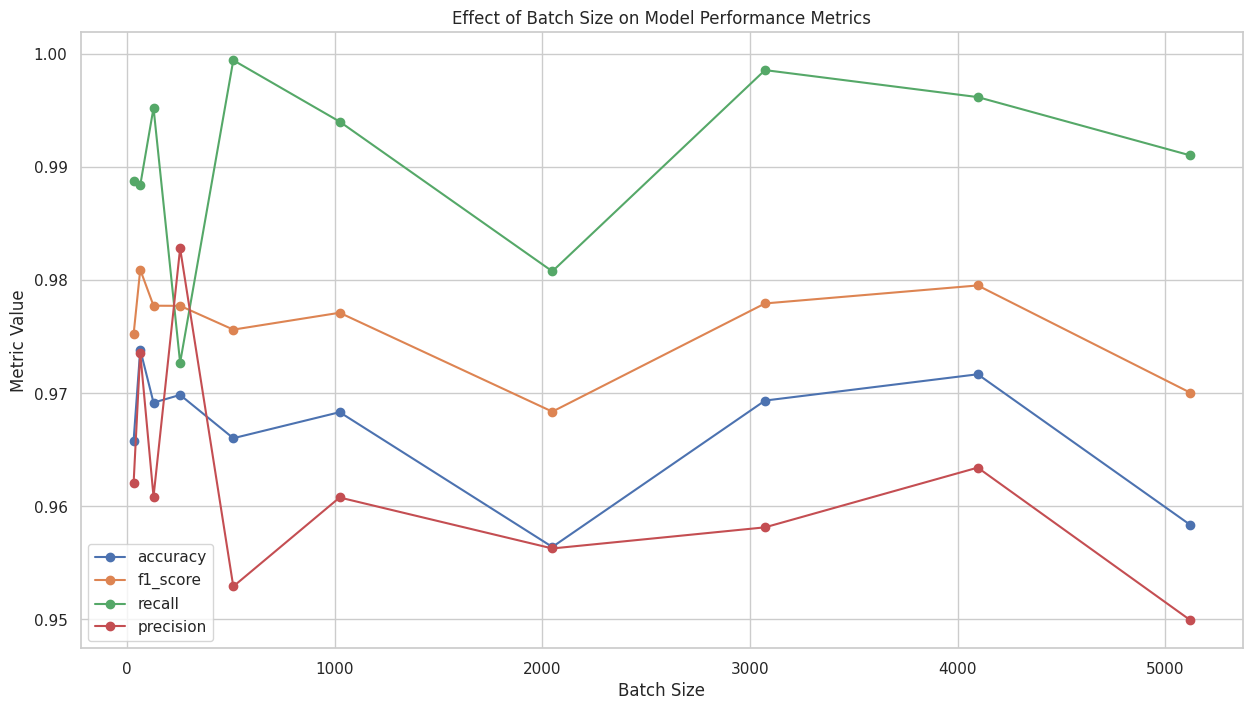

In [39]:
# Selected metrics for plotting
selected_metrics = ['accuracy', 'f1_score', 'recall', 'precision']

# Filter the DataFrame to include only selected metrics and 'batch_sizes'
df_filtered = df[['batch_sizes'] + selected_metrics]

# Plotting
plt.figure(figsize=(15, 8))
for metric in selected_metrics:
    plt.plot(df_filtered['batch_sizes'], df_filtered[metric], label=metric, marker='o')

plt.xlabel('Batch Size')
plt.ylabel('Metric Value')
plt.title('Effect of Batch Size on Model Performance Metrics')
# Save the plot as a PNG file
plt.savefig('model_performance_batch_sizes.png')
plt.legend()
plt.grid(True)
plt.show()

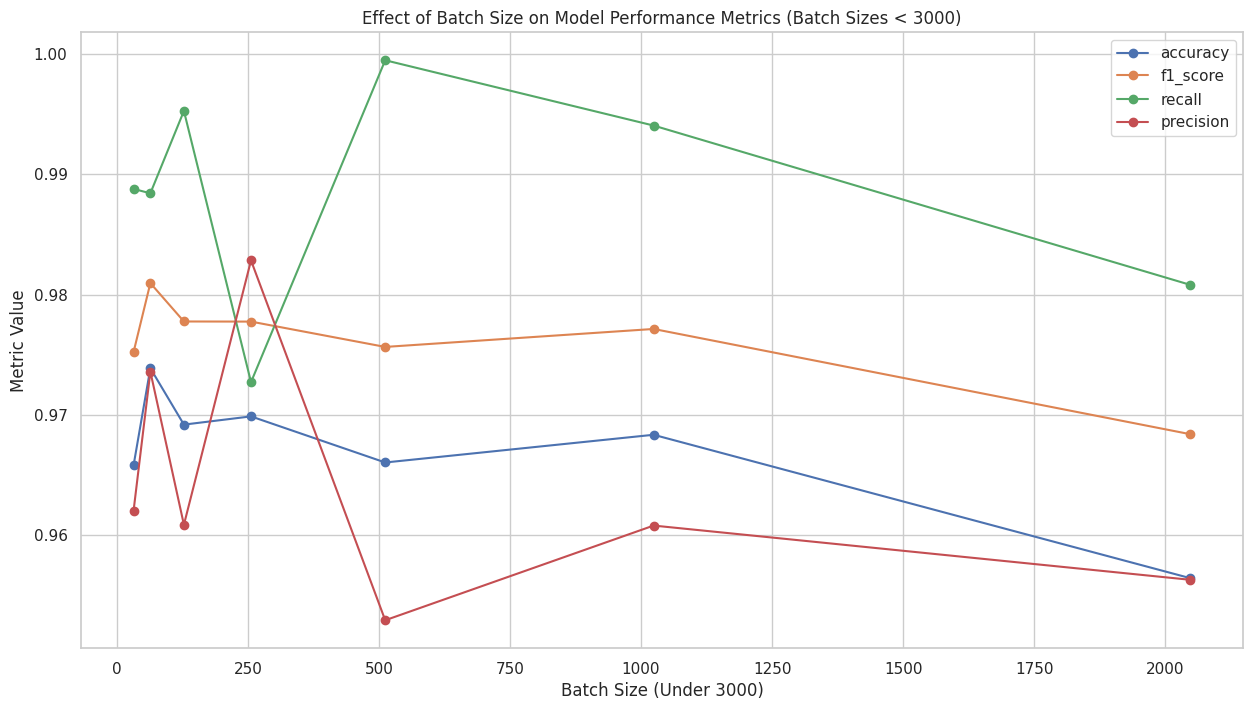

In [38]:
# Filter the DataFrame to include only batch sizes under 3000
df_filtered_under_3000 = df[df['batch_sizes'] < 3000]

# Plotting the data for batch sizes under 3000
plt.figure(figsize=(15, 8))
for metric in selected_metrics:
    plt.plot(df_filtered_under_3000['batch_sizes'], df_filtered_under_3000[metric], label=metric, marker='o')

plt.xlabel('Batch Size (Under 3000)')
plt.ylabel('Metric Value')
plt.title('Effect of Batch Size on Model Performance Metrics (Batch Sizes < 3000)')
plt.legend()
plt.grid(True)
# Save the plot as a PNG file
plt.savefig('model_performance_batch_sizes_under_3000.png')
# Save the plot as a PNG file
plt.savefig('model_performance_batch_sizes_under_3000.png')
plt.show()
